In [1]:
import os

from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
import importlib
import torch as T
import gymnasium as gym

from pathlib import Path

import policygradient
importlib.reload(policygradient)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

### Initializing the Environment

In [2]:
env_id = "CartPole-v1"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-1.6440418e+00  1.0532785e+38  3.7584516e-01  1.8183399e+38]


In [3]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [9]:
layer1 = 32
layer2 = 64
gamma = 0.99
episodes = 100_000
lr_actor = 0.0001
lr_critic = 0.0001

# Average window size. The size of the silding window
# used to calculate the mean reward across the last N episodes
# where N is the avg_win_size

avg_win_size = 20
epi_results = deque(maxlen=avg_win_size)
actor_loss_results = deque(maxlen=avg_win_size)
critic_loss_results = deque(maxlen=avg_win_size)

# Initialize Agent
agent = policygradient.ActorCritic(s_size, a_size, layer1, layer2, gamma,
                                  lr_ac = lr_actor, lr_cr = lr_critic)

In [10]:
# model and log file names
log_file_name = os.path.join('.','artefacts',f'{env_id}_actor_critic_v1.csv')
model_file = os.path.join('.','models',f'{env_id}_actor_critic.pth')

In [11]:
#Set train flag to True to train the agent
#or False to load a trained agent saved in model_file
steps = 0
train = True

if train:
    # Delete old trainig log if exists
    if os.path.exists(log_file_name):
        os.remove(log_file_name)

    log_file = open(log_file_name, "w")
    log_file.write(f'episode,rewards,actor_loss,critic_loss\n')

    for epi in range(episodes):

        s = env.reset()[0]
        done, trunc = False, False
        rewards = 0
        while not any([done, trunc]):

            state = T.FloatTensor(np.expand_dims(s,0)).to(device)
            with T.no_grad():
                p_vals = agent.actor(state).squeeze().detach().cpu().numpy()

            a = np.random.choice(a_size, p=p_vals)
            s_, r, done ,trunc , _  = env.step(a)

            actor_loss, critic_loss = agent.learn(s, a, r*0.01, s_, done)
            actor_loss_results.append(actor_loss)
            critic_loss_results.append(critic_loss)

            steps+=1
            rewards += r
            s = s_

        epi_results.append(rewards)
        log_file.write(f'{epi},{rewards:.2f},{actor_loss:.4f},{critic_loss:.4f}\n')

        if epi % 10 == 0:
                print(f'{epi = } mean reward : {np.mean(epi_results):+6.2f} mean actor loss : {np.mean(actor_loss_results):+.4f} mean critic loss : {np.mean(critic_loss_results):.4f} steps = {steps}')

        if epi % 100 == 0:
            clear_output()

        if np.mean(epi_results)>=500:
            break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

Saving Agent as .\models\CartPole-v1_actor_critic.pth


### Evaluation

In [12]:
eval_agent = policygradient.ActorCritic(s_size, a_size, layer1, layer2, gamma)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Critic Loss')

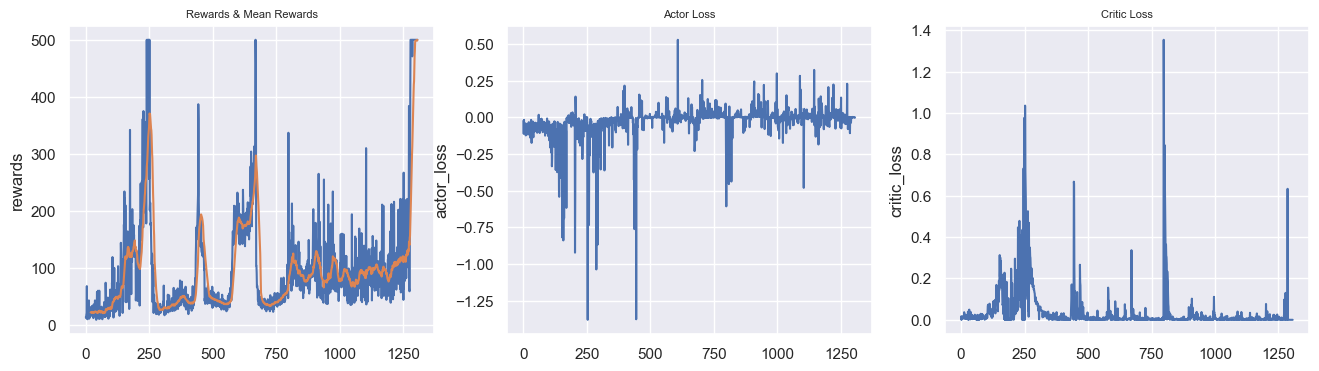

In [13]:
fig,ax=plt.subplots(1,3,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['actor_loss'],ax = ax[1])
ax[1].set_title('Actor Loss',fontsize=8)
sns.lineplot(df['critic_loss'],ax = ax[2])
ax[2].set_title('Critic Loss',fontsize=8)

In [14]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0

    while not any([term, trunc]):

        state = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = eval_agent.actor(state).squeeze().detach().cpu().numpy()
            
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
       
        score+=r
        
    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 500.00
epi = 1 result 500.00
epi = 2 result 500.00
epi = 3 result 500.00
epi = 4 result 500.00
epi = 5 result 500.00
epi = 6 result 500.00
epi = 7 result 500.00
epi = 8 result 500.00
epi = 9 result 500.00
